In [41]:
import tensorflow as tf 
import numpy as np 

Dataset mittels Keras importieren

In [4]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "Dataset",
    label_mode=None,
    image_size=(128,128),
    batch_size=8,
    smart_resize=True
)

Found 4319 files belonging to 1 classes.


Werte der Bilder normalisieren

In [5]:
dataset = dataset.map(lambda x: x/255.)

Testbild anzeigen

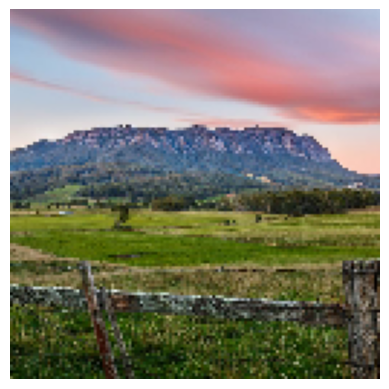

In [6]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

Generator erstellen

In [45]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)


In [46]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       6272      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 256)       524544    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 256)       1048832   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 flatten_3 (Flatten)         (None, 65536)           

In [47]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(3, kernel_size=6, padding="same", activation="tanh"),
    ],
    name="generator",
)

In [48]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 re_lu_16 (ReLU)             (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_8 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 32, 32, 256)      52

In [49]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [50]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"Generated Images\generated_img_{epoch:03d}_{i}.png")

In [51]:
epochs = 50

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.000001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
540/540 [==============================] - 101s 186ms/step - d_loss: 0.6985 - g_loss: 0.6918
Epoch 2/50
540/540 [==============================] - 100s 185ms/step - d_loss: 0.6895 - g_loss: 0.7532
Epoch 3/50
540/540 [==============================] - 101s 187ms/step - d_loss: 0.7717 - g_loss: 0.6005
Epoch 4/50
540/540 [==============================] - 101s 186ms/step - d_loss: 0.8112 - g_loss: 0.6259
Epoch 5/50
540/540 [==============================] - 100s 186ms/step - d_loss: 0.7726 - g_loss: 0.7500
Epoch 6/50
540/540 [==============================] - 100s 186ms/step - d_loss: 0.7630 - g_loss: 0.7354
Epoch 7/50
540/540 [==============================] - 100s 186ms/step - d_loss: 0.7560 - g_loss: 0.6864
Epoch 8/50
540/540 [==============================] - 97s 180ms/step - d_loss: 0.7473 - g_loss: 0.6776
Epoch 9/50
540/540 [==============================] - 99s 183ms/step - d_loss: 0.7432 - g_loss: 0.6702
Epoch 10/50
540/540 [==============================] - 100s 186ms/

In [52]:
generator.save('savedmodels\GeneratorDCGAN128x12804/01')

INFO:tensorflow:Assets written to: savedmodels\GeneratorDCGAN128x12804/01\assets


INFO:tensorflow:Assets written to: savedmodels\GeneratorDCGAN128x12804/01\assets


In [22]:
import tensorflow as tf
new_model = tf.keras.models.load_model('TLDNE\Model\savedmodels\Generator03\01')

OSError: No file or directory found at TLDNE\Model\savedmodels\Generator03

tf.Tensor([128 128   3], shape=(3,), dtype=int32)


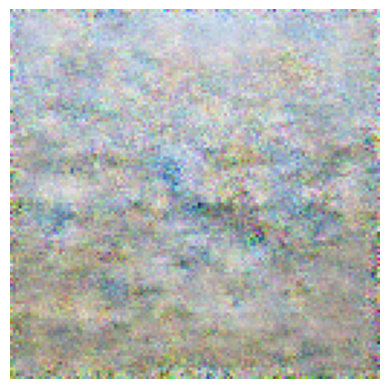

In [16]:
num = 1
random_vector = tf.random.normal(shape=(num, 128))
images = new_model(random_vector)
images *= 255
print(tf.shape(images[0]))

for x in range(num):
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)